---

### Quick introduction to LDA

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities. It is an unsupervised model, that can be compared to clustering in that it is only necessary to input the dataset, the number of topics required, and in this case, the number of words per topic. 
Other common topic-modeling algorithms are Latent Semantic Analysis (LSA) and Probabilistic LSA.


**Inputs**
- M number of documents
- N number of words
- K number of topics

**Outputs**
- psi: the distribution of words for each topic K
- phi: the distribution of topics for each document i

**Parameters of LDA**
- Alpha parameter: is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.


- Beta parameter: is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

---

### LDA Implementation
- Loading data
- Data cleaning
- Exploratory analysis
- Prepare data for LDA analysis
- LDA model training
- Analyzing LDA model results

---

## Step 1: Loading Data

In [2]:
# Load the previously exported Json file into a pandas dataframe for easy manipulation
import pandas as pd
import os

papers = pd.read_json('df_step3.json.bz2', compression='bz2', lines=True)

# Print some lines
papers.head()


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,date_of_birth,gender,nationality,occupation,party,academic_degree,candidacy,religion
0,2015-11-14-006404,"Brexit isn't in Ireland's economic interest,",Enda Kenny,[Q5375903],2015-11-14 02:32:37,1,"[[Enda Kenny, 0.9055], [None, 0.0945]]",[http://www.independent.ie/opinion/comment/no-...,E,2015,[],[male],[Australia],[songwriter],[],[],[],[]
1,2015-04-22-037418,Leaving would be economic madness-all that har...,Gary Lewis,[Q113949],2015-04-22 05:00:56,1,"[[Gary Lewis, 0.5536], [None, 0.3997], [Nigel ...",[http://www.director.co.uk/a1-pharmaceuticals/],E,2015,[+1958-11-30T00:00:00Z],[male],[United Kingdom],"[film actor, performing artist, stage actor, t...",[],[],[],[]
2,2015-11-05-013470,Brexit could prevent emigration that would oth...,Edgar Morgenroth,[Q57152834],2015-11-05 01:00:34,6,"[[Edgar Morgenroth, 0.9296], [None, 0.0704]]",[http://www.irishtimes.com/business/economy/br...,E,2015,[],[male],[],[researcher],[],[],[],[]
3,2015-02-01-004063,Brexit: How Britain Will Leave Europe.,Denis MacShane,[Q695061],2015-02-01 09:12:29,21,"[[Denis MacShane, 0.849], [None, 0.1059], [The...",[http://news.yahoo.com/greece-shakes-europes-p...,E,2015,[+1948-05-21T00:00:00Z],[male],[United Kingdom],"[politician, trade unionist]",[Labour Party],[],"[2010 United Kingdom general election, 2005 Un...",[]
4,2015-11-10-067367,leaving the EU is not some artificial fast-tra...,Chris Mason,[Q1077516],2015-11-10 11:25:37,1,"[[Chris Mason, 0.8921], [None, 0.0993], [David...",[http://mashable.com/2015/11/10/britain-brexit...,E,2015,[+1969-12-17T00:00:00Z],[male],[United Kingdom],[darts player],[],[],[],[]


---

## Step 2: Data Cleaning

In [3]:
# Load the regular expression library
import re

# Remove punctuation signs such as commas, exclamatory signs, quotation marks, etc
papers['paper_text_processed'] = \
papers['quotation'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the quotations to lowercase, to avoid considering lower cased or higher cased words differently
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of the dataset
papers['paper_text_processed'].head()

0          brexit isn't in ireland's economic interest
1    leaving would be economic madness-all that har...
2    brexit could prevent emigration that would oth...
3                brexit: how britain will leave europe
4    leaving the eu is not some artificial fast-tra...
Name: paper_text_processed, dtype: object

---

## Step 3: Exploratory Analysis

Preivous to the LDA algorith, we will perform a simple, visual representation of the words with most appearances in the quotes dataset. Fo this purpose, we will import wordcloud, that represents words' size according to their number of appearandes. 

In [ ]:
# install the package into the environment
pip install wordcloud

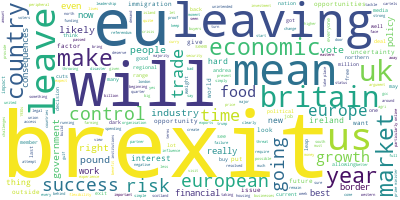

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

---

## Step 4: Prepare text for LDA analysis

LDA requires a special format of words, in which an index is associated with the word repetition inside the document. Firstly, we tokenize the text to obtain individual words and remove stopwords. Finally, we convert the cleaned text into a corpus of terms and a dictionary with their number of appearances.

*1) Tokenize and remove stopwords*

In [ ]:
# slow process, dont run if you already have it installed in your computer
# library required to train the LDA algorithm
pip install gensim 

In [ ]:
# the library required to obtain tokens and remove stopwords
pip install nltk

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk

# download the nltk package of typical stopwords in a definite language, in this case, english
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# define an auxiliar method that will remove punctuations and obtain token words in a quote/sentence
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# define an auxiliar method to remove the stopwords from a given tokenized text
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# obtain a list of all quotes inside the dataframe "papers" and the column "paper_text_processed"
data = papers.paper_text_processed.values.tolist()

# apply the auxiliar method "sent_to_words" to obtain the tokens and remove punctuations
data_words = list(sent_to_words(data))

# apply the auxiliar method "remove_stopwords" to remove the defined stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['brexit', 'ireland', 'economic', 'interest']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*2) Convert into corpus and dictionary*

In [7]:
import gensim.corpora as corpora

# create a corpus based on the list "data_words" obtained in the previous step
id2word = corpora.Dictionary(data_words)
texts = data_words

# create a dictionary in which the values are the frequency of the words in the quote
corpus = [id2word.doc2bow(text) for text in texts]

# View the dictionary equivalent to the previous word visualization
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


---

## Step 5: LDA model tranining

We will build a model with K = num_topics, topics where each topic is a combination of keywords, and each keyword contributes a certain weigh to the topic.

In [8]:
from pprint import pprint

# define the number of topics
num_topics = 15

# build LDA model using the gensim package and train it in an unsupervised way with the corpus, dictionary and K topics predefined before
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print the topic definition in the K topics
# each topic is composed by 10 words, each of which has a weight inside the topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"brexit" + 0.038*"would" + 0.022*"eu" + 0.011*"dark" + '
  '0.011*"success" + 0.011*"risk" + 0.011*"threat" + 0.011*"well" + '
  '0.011*"access" + 0.011*"market"'),
 (1,
  '0.032*"economic" + 0.032*"brexit" + 0.022*"legal" + 0.015*"uk" + '
  '0.011*"respect" + 0.011*"structure" + 0.011*"arrangements" + '
  '0.011*"meantime" + 0.011*"seems" + 0.011*"faced"'),
 (2,
  '0.050*"brexit" + 0.025*"britain" + 0.017*"could" + 0.017*"leave" + '
  '0.017*"us" + 0.017*"europe" + 0.017*"eu" + 0.017*"western" + 0.009*"better" '
  '+ 0.009*"heart"'),
 (3,
  '0.043*"brexit" + 0.017*"put" + 0.017*"rights" + 0.017*"right" + '
  '0.017*"risk" + 0.017*"government" + 0.017*"leaving" + 0.017*"economic" + '
  '0.017*"people" + 0.009*"frustration"'),
 (4,
  '0.037*"would" + 0.029*"eu" + 0.027*"brexit" + 0.020*"leaving" + '
  '0.016*"food" + 0.010*"issue" + 0.010*"industry" + 0.010*"ireland" + '
  '0.010*"northern" + 0.010*"agri"'),
 (5,
  '0.027*"free" + 0.021*"brexit" + 0.014*"licence" + 0.014*"

---

## Step 6: Analyzing our LDA model

To better interpret the results, it is interesting to do it interactively and visually. We will employ pyLDAvis package that allows to:

1. Better understand and interpreting individual topics.
2. Better understand the relationships between the topics.


For the topic interpretation, you can select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. When λ = 1 you can see the most frequent terms in the top of the list, and their frequency inside the topic. When λ = 0, then more weight is given to words that only appear in that topic, and not so much in the rest, this is, more 'unique' words, which help you understand the topic in an 'unique' or 'differential' way. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For the relationship between the topics, it is possible to explore the Intertopic Distance Plot. In this case, the pyLDAvis package extracts the two most important Principal Components (PC1, PC2) and separates them according to their 'closeness'. This can help you learn about how topics are related to each other, see which ones are ovelapped which means that they share many words, or characteristics, and when several topics are really overlapping, this could indicate that maybe a greater topic that englobes all of them should be defined. 

In [ ]:
pip install pyLDAvis

In [ ]:
pip install pickle

In [9]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

# prepare the environment for the pyLDAvis package and define where the results should be stored
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# create the LDA model for visualization, with the word frequency and the intertopic distance
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# for easy visualization in an html page, the results are saved in an appropriate format
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\Users\soria\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\soria\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.160756 -0.018823       1        1  12.242415
8     -0.019902 -0.169854       2        1   9.854328
4     -0.109566  0.033629       3        1   9.594240
0     -0.067414  0.065332       4        1   9.399267
13    -0.039963 -0.044676       5        1   9.044665
12    -0.036168  0.062359       6        1   8.167227
11     0.151134  0.051684       7        1   8.083707
14     0.001793  0.053110       8        1   7.165874
10     0.002896 -0.113978       9        1   6.377502
2      0.018821  0.014902      10        1   5.070056
3     -0.012894  0.039747      11        1   4.530552
9     -0.040068 -0.020528      12        1   3.988656
1      0.000110  0.034755      13        1   3.059720
5     -0.016149  0.002107      14        1   2.321757
6      0.006615  0.010234      15        1   1.100033, topic_info=         Term       Freq      Total Category  logprob  loglift
249     means   9.000000   9.000000  Default  30.0000  30.0000
47    britain   7.000000   7.000000  Default  29.0000  29.0000
1    economic   5.000000   5.000000  Default  28.0000  28.0000
41      would  19.000000  19.000000  Default  27.0000  27.0000
85     growth   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
137        uk   0.015349   6.996586  Topic15  -6.9168  -1.6123
249     means   0.015349   9.240166  Topic15  -6.9168  -1.8904
274    simple   0.015349   2.032957  Topic15  -6.9168  -0.3763
3     ireland   0.015349   2.965659  Topic15  -6.9168  -0.7540
212      vote   0.015349   4.012900  Topic15  -6.9168  -1.0564

[707 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
253       4  0.496656      access
618      11  0.877002     account
718       3  0.777105         add
560       6  0.779876  additional
719       3  0.777101  advantages
...     ...       ...         ...
71        1  0.294363       years
71        3  0.294363       years
71        4  0.294363       years
308       8  0.808111         yet
491       4  0.764655        zero

[675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 5, 1, 14, 13, 12, 15, 11, 3, 4, 10, 2, 6, 7])

---

### References:
- Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
- Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
- Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
- A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf